# TPZ on protoDC2

By: Bela Abolfathi & Will Hartley

Here we TPZ trees on protoDC2 data (http://matias-ck.com/mlz/tpz.html) to be used in the TXPipe framework. The first model is trained on an optimisitc sample, while the second model has been trained on more pessimisstic data - that is, data selected from protoDC2 made to have a flat histogram in i-band magnitude. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from mlz.ml_codes import *

In [3]:
def prepare_df(df):
    
    input_df = pd.DataFrame()

    input_df['zs'] = df['redshift']
    input_df['u'] = df['scatmag_u']
    input_df['g'] = df['scatmag_g']
    input_df['r'] = df['scatmag_r']
    input_df['i'] = df['scatmag_i']
    input_df['z'] = df['scatmag_z']
    input_df['y'] = df['scatmag_y']

    u_g = df['scatmag_u'] - df['scatmag_g']
    g_r = df['scatmag_g'] - df['scatmag_r']
    r_i = df['scatmag_r'] - df['scatmag_i']
    i_z = df['scatmag_i'] - df['scatmag_z']
    z_y = df['scatmag_z'] - df['scatmag_y']

    input_df['u-g'] = u_g
    input_df['g-r'] = g_r
    input_df['r-i'] = r_i
    input_df['i-z'] = i_z
    input_df['z-y'] = z_y
    
    return(input_df)

def prepare_training_data(df, seed, test_size):
    ## Split the data into training and test samples, and separate the features from the redshift
    train, test = train_test_split(df, test_size=test_size, random_state=seed)
    return(train.loc[:,'u':'z-y'], train.loc[:,'zs'])

In [4]:
seed = 123
save_path = "data/"

d = {'u': {'ind': 0}, 'g': {'ind': 1}, 'r': {'ind': 2}, 'i': {'ind': 3}, 'z': {'ind': 4}, 'z': {'ind': 4}, 
     'u-g': {'ind': 5}, 'g-r': {'ind': 6}, 'r-i': {'ind': 6}, 'i-z': {'ind': 6}, 'z-y': {'ind': 6}}

features = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst', 'mag_y_lsst', 'mag_u_lsst-mag_g_lsst', 
            'mag_g_lsst-mag_r_lsst', 'mag_r_lsst-mag_i_lsst', 'mag_i_lsst-mag_z_lsst', 'mag_z_lsst-mag_y_lsst']

## Model 1

In [5]:
## Get the data
path = "/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/protoDC2v5"
infile = "protodc2_v5_ugrizy_witherrs.h5"
fullpath = os.path.join(path,infile)

## Put it in a pandas data frame
df = pd.read_hdf(fullpath)
## df.info()

In [6]:
test_size = 0.4
input_df = prepare_df(df)
cols_mags, redshifts = prepare_training_data(input_df, seed, test_size)

In [8]:
## Create a forest from a set of decision trees and save
n_trees = 10
Trees = [TPZ.Rtree(cols_mags.as_matrix()[::100], redshifts.as_matrix()[::100], minleaf=30, mstar=3, dict_dim=d, 
                   forest='yes') for i in range(n_trees)]
print(len(cols_mags.as_matrix()[::100]))
save(os.path.join(save_path, 'protoDC2_trees_109721.npy'), [features, Trees])

109721


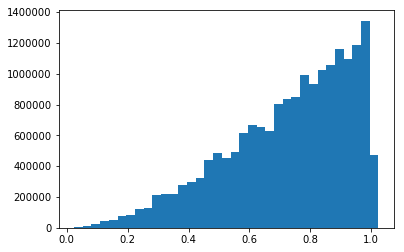

In [9]:
plt.hist(input_df['zs'], bins=35)
plt.show()

## Model 2

Now we want to train on a pessimisstic sample generated by Sam Schmidt:  
https://github.com/LSSTDESC/pz_pdf/blob/u/sschmidt23/uniform_train/notebooks/protoDC2v5_uniform_training_selection.ipynb

Data from: /global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/protoDC2v5/protodc2_v5_ugrizy_witherrs_flat_training.h5

In [10]:
infile = "protodc2_v5_ugrizy_witherrs_flat_training.h5"
fullpath = os.path.join(path,infile)
flat_df = pd.read_hdf(fullpath)
## flat_df.info()

## Select objects from the flat histogram sample
flat_train = flat_df['flat_training_flag'] == True
flat_train_df = prepare_df(flat_df[flat_train])

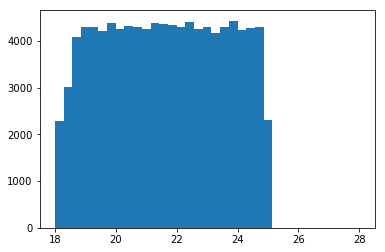

In [11]:
plt.hist(flat_df[flat_train]['scatmag_i'], bins=35, range=(18., 28.))
plt.show()

In [12]:
test_size = 0.2
cols_mags, redshifts = prepare_training_data(flat_train_df, seed, test_size)

In [13]:
## Create a forest from a set of decision trees 
n_trees = 10
Trees = [TPZ.Rtree(cols_mags.as_matrix(), redshifts.as_matrix(), minleaf=30, mstar=3, dict_dim=d, 
                   forest='yes') for i in range(n_trees)]
print(len(cols_mags.as_matrix()))
save(os.path.join(save_path, 'protoDC2_flat_training_trees_85861.npy'), [features, Trees])

85861
